<a href="https://colab.research.google.com/github/stakunlena/ich_python_for_DA_HW/blob/main/Stakun_HW_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Домашняя работа №19**

1. Повторите первичный анализ датасета used_cars_data после всех преобразований, сделанных на уроке. Определите, типы каких столбцов теперь можно изменить. Сделайте это.
1. Повторите одномерный анализ прологорифмированных столбцов и столбцов, в которых были заполнены пропущенные значения.
1. Выведите информацию о самых крайних выбросах всех столбцов. Проанализируйте, есть ли среди них ошибки ввода. Ликвидируйте их любым способом, учитывающим специфику данных

In [22]:
# Работа с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("/content/drive/MyDrive/Python for data analysis/HW_19_dataset/data_19_2.csv")
data.head(5)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Car_Age,Brand,Model,Kilometers_Driven_log,Price_log
0,Mumbai,2010,72000,CNG,Manual,First,35.4578,998.0,58.16,5.0,NaN,1.75,15,Maruti,Wagon R LXI CNG,11.184435,1.011601
1,Pune,2015,41000,Diesel,Manual,First,19.6700,1582.0,126.20,5.0,NaN,12.50,10,Hyundai,Creta 1.6 CRDi SX Option,10.621352,2.602690
2,Chennai,2011,46000,Petrol,Manual,First,18.2000,1199.0,88.70,5.0,8.61,4.50,14,Honda,Jazz V,10.736418,1.704748
3,Chennai,2012,87000,Diesel,Manual,First,20.7700,1248.0,88.76,7.0,NaN,6.00,13,Maruti,Ertiga VDI,11.373675,1.945910
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2000,1968.0,140.80,5.0,NaN,17.74,12,Audi,A4 New 2.0 TDI Multitronic,10.613271,2.930660


In [17]:
def eda_plot(
    df: pd.DataFrame,
    column_name: str,
    title: str = "",
    bins: int = 30,
    show_stats: bool = True,
    normalize: bool = False,
    include_na: bool = True
) -> None:
    """
    Универсальная функция для проведения разведочного анализа данных (EDA).

    Автоматически определяет тип признака (числовой или категориальный) и визуализирует распределение:
    - для числовых признаков: boxplot + histplot + таблица статистик;
    - для категориальных признаков: barplot с количеством или долями.

    Параметры
    ----------
    df : pd.DataFrame
        Исходный DataFrame с данными.
    column_name : str
        Название столбца для анализа.
    title : str, optional
        Заголовок графика (по умолчанию — имя признака).
    bins : int, optional
        Количество бинов для гистограммы (по умолчанию 30).
    show_stats : bool, optional
        Если True — выводит таблицу статистик/частот.
    normalize : bool, optional
        Если True — отображает распределение в процентах (для категориальных признаков).
    include_na : bool, optional
        Если True — включает NaN в таблицу частот и проценты (по умолчанию True).

    Возвращает
    ----------
    None
        Функция отображает графики и таблицы прямо в Jupyter Notebook.
    """
    if column_name not in df.columns:
        raise ValueError(f"Столбец '{column_name}' отсутствует в DataFrame.")

    series = df[column_name]
    dtype = series.dtype

    # --- фильтрация пропусков для визуализации ---
    if not include_na:
        series = series.dropna()

    if series.empty:
        print(f"Столбец '{column_name}' содержит только пропуски. Пропущен.")
        return

    # === ЧИСЛОВЫЕ ПРИЗНАКИ ===
    if pd.api.types.is_numeric_dtype(dtype):
        fig, (ax_box, ax_hist) = plt.subplots(
            nrows=2, figsize=(7, 4), sharex=True,
            gridspec_kw={"height_ratios": [0.15, 0.85]}
        )

        sns.boxplot(x=series, ax=ax_box, color="#4C72B0")
        sns.histplot(x=series, bins=bins, kde=True, ax=ax_hist, color="#4C72B0")

        ax_box.set(title=title or column_name, xlabel="")
        ax_box.grid(False)
        ax_hist.set_xlabel(column_name)
        ax_hist.set_ylabel("Частота")

        plt.tight_layout()
        plt.show()

        if show_stats:
            stats = series.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).to_dict()
            stats.update({
                "missing": df[column_name].isna().sum(),
                "zeros": (df[column_name] == 0).sum(),
                "negatives": (df[column_name] < 0).sum()
            })
            formatted_stats = {}
            for k, v in stats.items():
                if k == "count":
                    formatted_stats[k] = int(v)
                elif k in ["mean", "std"]:
                    formatted_stats[k] = round(v, 2)
                else:
                    formatted_stats[k] = v
            display(pd.DataFrame(formatted_stats, index=[column_name]).T)

    # === КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ===
    else:
        # --- Подгонка размера графика под количество баров ---
        n_cats = series.nunique(dropna=not include_na)
        height = max(5, min(15, n_cats * 0.4))  # минимум 5, максимум 15 (чтобы не было слишком огромных графиков)

        plt.figure(figsize=(7, height))

        # Расчёт значений
        dropna_flag = not include_na
        value_counts = (
            series.value_counts(dropna=dropna_flag, normalize=normalize)
            * (100 if normalize else 1)
        )

        sns.barplot(
            y=value_counts.index,
            x=value_counts.values,
            hue=value_counts.index, # исправление для Seaborn ≥0.14
            palette="Blues_d",
            orient="h",
            legend=False,
            order=value_counts.index # сохраняем исходный порядок баров
        )

        plt.title(title or column_name)
        plt.xlabel("Доля, %" if normalize else "Количество")
        plt.ylabel(column_name)

        # Добавляем подписи на барах
        for i, v in enumerate(value_counts.values):
            plt.text(
                v + max(value_counts.values) * 0.01,
                i,
                f"{v:.1f}" + ("%" if normalize else ""),
                va="center",
                fontsize=9
            )

        # Подгонка размера графика под количество баров
        plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.05)
        plt.show()

        if show_stats:
            freq = series.value_counts(dropna=not include_na).to_frame("count")
            freq["%"] = (freq["count"] / (len(series) if not include_na else len(df)) * 100).round(2)

            # --- Проверка артефактов ---
            artifact_values = ["False", "None", "Na", "NaN", "<NA>", "", " "]
            artifact_mask = series.astype(str).isin(artifact_values)
            artifact_count = artifact_mask.sum()
            missing_count = series.isna().sum()

            print(f"\n=== Проверка пропусков и артефактов ===")
            print(f"Пропусков (NaN): {missing_count}")
            print(f"Артефактных значений: {artifact_count}")
            if artifact_count > 0:
                detected = series[artifact_mask].unique().tolist()
                print(f"Обнаружены артефакты: {detected}")
            display(freq)

def clip_or_trim(
    df: pd.DataFrame,
    column: str,
    lower_q: float = 0.0,
    upper_q: float = 0.75,
    mode: str = "trim",
    log_transform: bool = False,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Универсальная функция для устранения влияния выбросов:
    выполняет либо усечение (trimming), либо винзоризацию (winsorization).

    Параметры
    ----------
    df : pd.DataFrame
        Исходный DataFrame.
    column : str
        Название числового столбца для обработки.
    lower_q : float, optional
        Нижний квантиль (по умолчанию 0.0 — без нижнего отсечения).
    upper_q : float, optional
        Верхний квантиль для отсечения (по умолчанию 0.75 — Q3).
    mode : {"trim", "winsor"}, optional
        Режим обработки:
        - "trim"   — удалить строки, где значение вне диапазона [Qlow, Qhigh];
        - "winsor" — заменить значения за пределами диапазона пороговыми.
    log_transform : bool, optional
        Если True, добавляет логарифмированный столбец (log1p).
    verbose : bool, optional
        Если True, выводит сводку с количеством обработанных строк.

    Возвращает
    ----------
    df_out : pd.DataFrame
        Новый DataFrame с обработанным столбцом.
    """
    if column not in df.columns:
        raise ValueError(f"Столбец '{column}' отсутствует в DataFrame.")

    # Квантили
    q_low = df[column].quantile(lower_q)
    q_high = df[column].quantile(upper_q)

    # Копия для безопасной работы
    df_out = df.copy()

    if mode == "trim":
        # --- trimming: удаляем строки за пределами диапазона
        before = len(df_out)
        df_out = df_out[(df_out[column] >= q_low) & (df_out[column] <= q_high)].copy()
        after = len(df_out)
        if verbose:
            print(f"[TRIM] Удалено строк: {before - after} (осталось {after})")
            print(f"Диапазон данных: {q_low:.2f} — {q_high:.2f}")

    elif mode == "winsor":
        # --- winsorization: заменяем значения на пороговые
        before_extreme = ((df_out[column] < q_low) | (df_out[column] > q_high)).sum()
        df_out[column] = np.clip(df_out[column], q_low, q_high)
        after_extreme = ((df_out[column] < q_low) | (df_out[column] > q_high)).sum()
        if verbose:
            print(f"[WINSOR] Заменено экстремальных значений: {before_extreme}")
            print(f"Диапазон после обрезки: {df_out[column].min():.2f} — {df_out[column].max():.2f}")

    else:
        raise ValueError("Параметр 'mode' должен быть 'trim' или 'winsor'.")

    # Добавляем логарифмированный столбец, если нужно
    if log_transform:
        log_col = f"log_{column}"
        df_out[log_col] = np.log1p(df_out[column])
        if verbose:
            print(f"Добавлен столбец '{log_col}' (логарифм + 1).")

    return df_out


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               7253 non-null   object 
 1   Year                   7253 non-null   int64  
 2   Kilometers_Driven      7253 non-null   int64  
 3   Fuel_Type              7253 non-null   object 
 4   Transmission           7253 non-null   object 
 5   Owner_Type             7253 non-null   object 
 6   Mileage                7253 non-null   float64
 7   Engine                 7213 non-null   float64
 8   Power                  7117 non-null   float64
 9   Seats                  7207 non-null   float64
 10  New_Price              1006 non-null   float64
 11  Price                  6019 non-null   float64
 12  Car_Age                7253 non-null   int64  
 13  Brand                  7253 non-null   object 
 14  Model                  7253 non-null   object 
 15  Kilo

2. Повторите одномерный анализ прологорифмированных столбцов и столбцов, в которых были заполнены пропущенные значения.

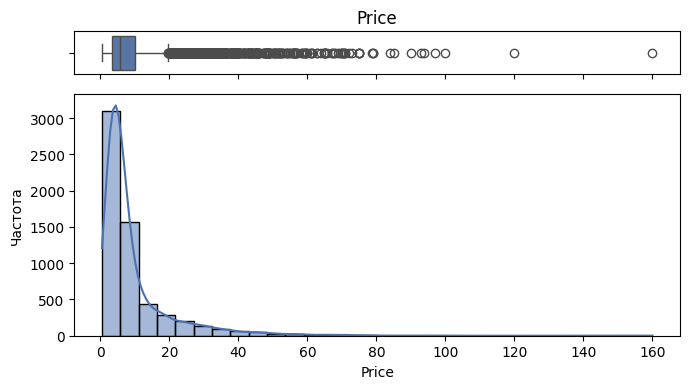

,Price
count,6019.00
mean,9.48
std,11.19
min,0.44
1%,0.90
25%,3.50
50%,5.64
75%,9.95
99%,56.00
max,160.00


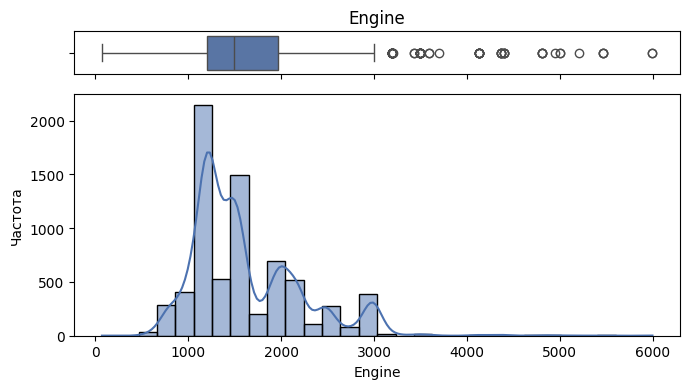

,Engine
count,7213.00
mean,1616.35
std,595.10
min,72.00
1%,796.00
25%,1198.00
50%,1493.00
75%,1968.00
99%,2996.00
max,5998.00


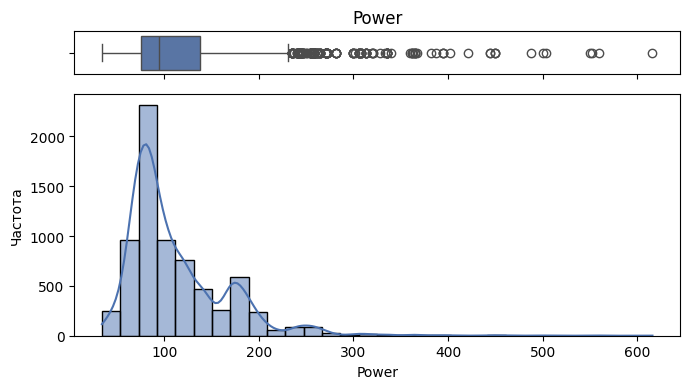

,Power
count,7117.0000
mean,112.5500
std,53.4300
min,34.2000
1%,38.7040
25%,75.0000
50%,94.0000
75%,138.1000
99%,281.9376
max,616.0000


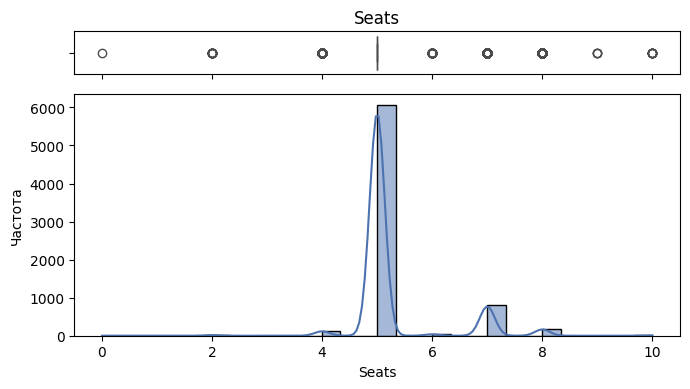

,Seats
count,7207.00
mean,5.28
std,0.81
min,0.00
1%,4.00
25%,5.00
50%,5.00
75%,5.00
99%,8.00
max,10.00


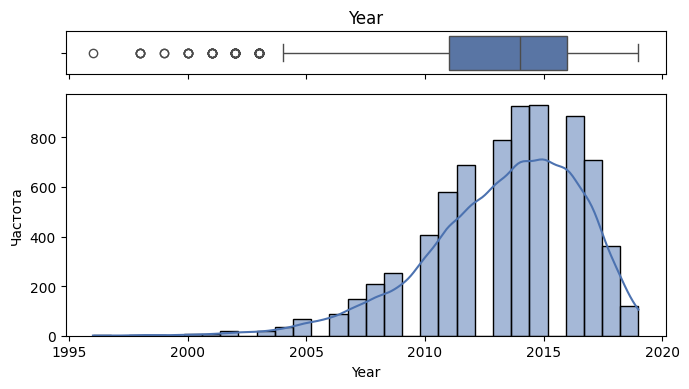

,Year
count,7253.00
mean,2013.37
std,3.25
min,1996.00
1%,2004.00
25%,2011.00
50%,2014.00
75%,2016.00
99%,2019.00
max,2019.00


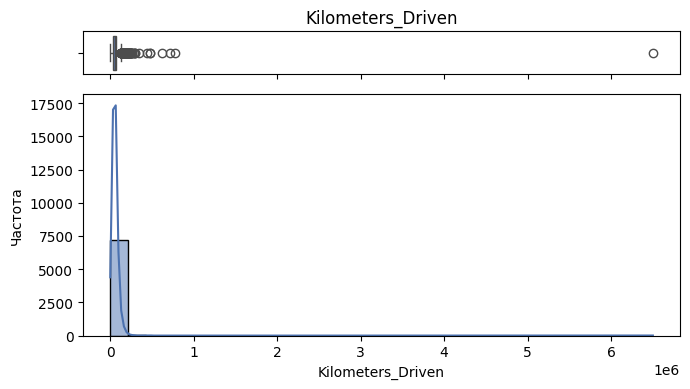

,Kilometers_Driven
count,7253.00
mean,58699.06
std,84427.72
min,171.00
1%,4074.16
25%,34000.00
50%,53416.00
75%,73000.00
99%,173480.00
max,6500000.00


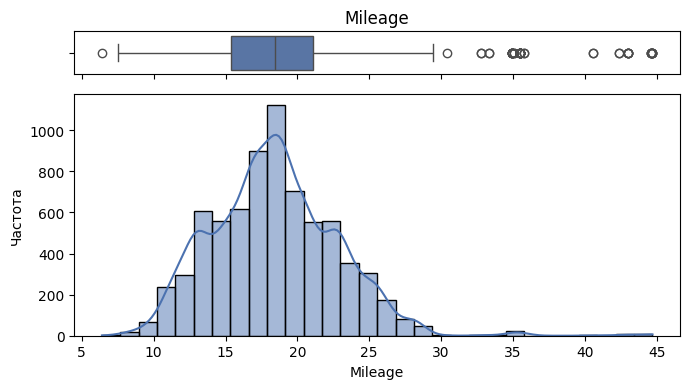

,Mileage
count,7253.000000
mean,18.430000
std,4.370000
min,6.400000
1%,10.100000
25%,15.400000
50%,18.430217
75%,21.100000
99%,28.400000
max,44.708820


In [19]:
numeric_columns = ['Price', 'Engine', 'Power', 'Seats', 'Year', 'Kilometers_Driven', 'Mileage']
for i, col in enumerate(numeric_columns, 1):
  eda_plot(data, col)

3. Выведите информацию о самых крайних выбросах всех столбцов. Проанализируйте, есть ли среди них ошибки ввода. Ликвидируйте их любым способом, учитывающим специфику данных

Обрабатываем выбросы — логарифмируем и винзоризируем с помощью кастомной функции clip_or_trim

In [20]:
for i, col in enumerate(numeric_columns, 1):
  data = clip_or_trim(data, col, mode="winsor", log_transform=True, verbose=True)

[WINSOR] Заменено экстремальных значений: 1504
Диапазон после обрезки: 0.44 — 9.95
Добавлен столбец 'log_Price' (логарифм + 1).
[WINSOR] Заменено экстремальных значений: 1794
Диапазон после обрезки: 72.00 — 1968.00
Добавлен столбец 'log_Engine' (логарифм + 1).
[WINSOR] Заменено экстремальных значений: 1730
Диапазон после обрезки: 34.20 — 138.10
Добавлен столбец 'log_Power' (логарифм + 1).
[WINSOR] Заменено экстремальных значений: 1015
Диапазон после обрезки: 0.00 — 5.00
Добавлен столбец 'log_Seats' (логарифм + 1).
[WINSOR] Заменено экстремальных значений: 1189
Диапазон после обрезки: 1996.00 — 2016.00
Добавлен столбец 'log_Year' (логарифм + 1).
[WINSOR] Заменено экстремальных значений: 1809
Диапазон после обрезки: 171.00 — 73000.00
Добавлен столбец 'log_Kilometers_Driven' (логарифм + 1).
[WINSOR] Заменено экстремальных значений: 1747
Диапазон после обрезки: 6.40 — 21.10
Добавлен столбец 'log_Mileage' (логарифм + 1).


Смотрим полученный результат

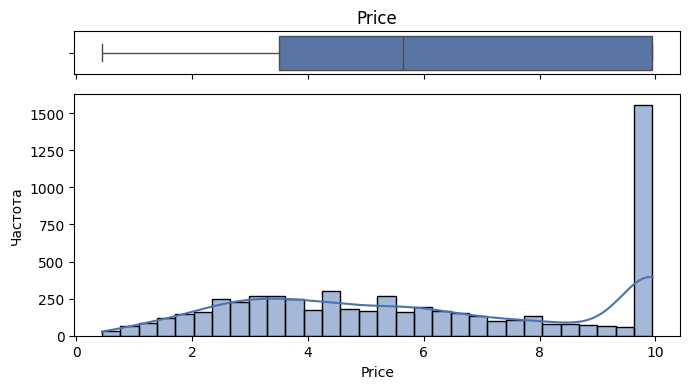

,Price
count,6019.00
mean,6.03
std,2.95
min,0.44
1%,0.90
25%,3.50
50%,5.64
75%,9.95
99%,9.95
max,9.95


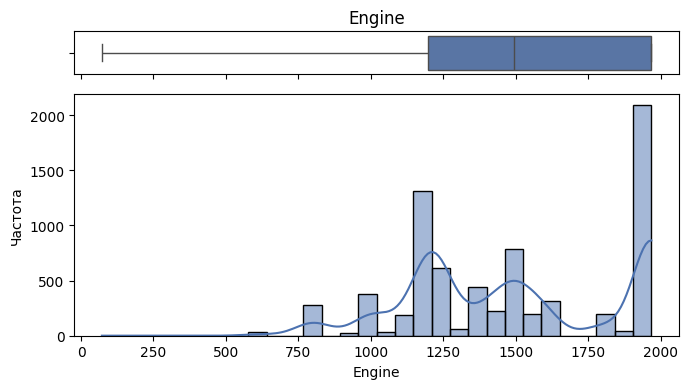

,Engine
count,7213.00
mean,1493.20
std,364.31
min,72.00
1%,796.00
25%,1198.00
50%,1493.00
75%,1968.00
99%,1968.00
max,1968.00


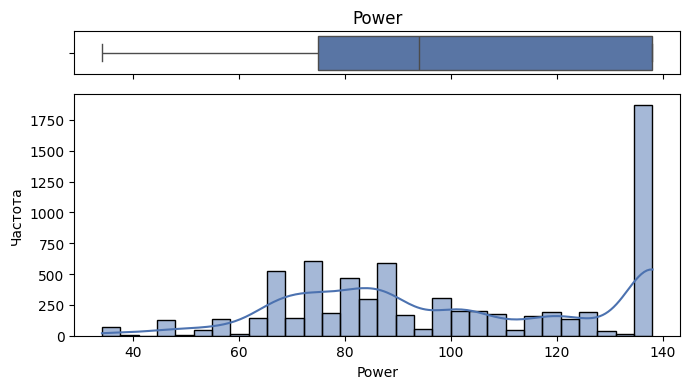

,Power
count,7117.000
mean,100.130
std,28.690
min,34.200
1%,38.704
25%,75.000
50%,94.000
75%,138.100
99%,138.100
max,138.100


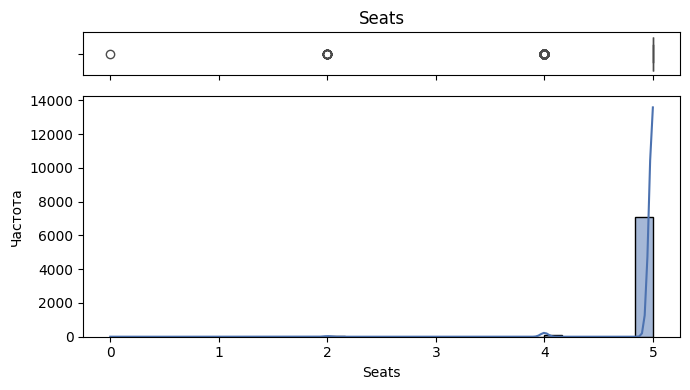

,Seats
count,7207.00
mean,4.98
std,0.20
min,0.00
1%,4.00
25%,5.00
50%,5.00
75%,5.00
99%,5.00
max,5.00


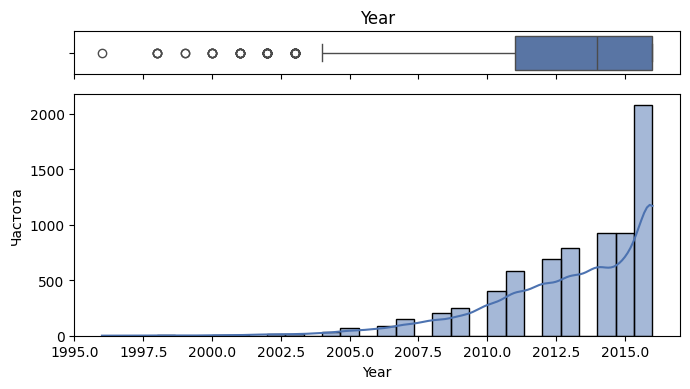

,Year
count,7253.00
mean,2013.12
std,2.96
min,1996.00
1%,2004.00
25%,2011.00
50%,2014.00
75%,2016.00
99%,2016.00
max,2016.00


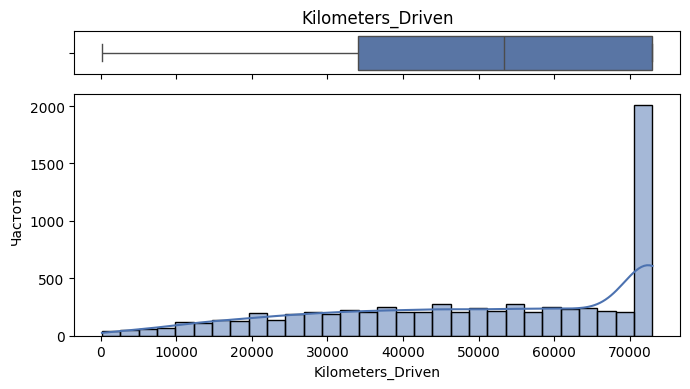

,Kilometers_Driven
count,7253.00
mean,50202.00
std,20627.77
min,171.00
1%,4074.16
25%,34000.00
50%,53416.00
75%,73000.00
99%,73000.00
max,73000.00


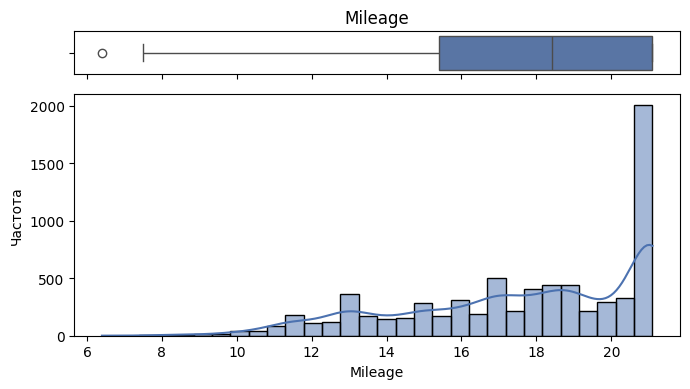

,Mileage
count,7253.000000
mean,17.680000
std,3.160000
min,6.400000
1%,10.100000
25%,15.400000
50%,18.430217
75%,21.100000
99%,21.100000
max,21.100000


In [21]:
for i, col in enumerate(numeric_columns, 1):
  eda_plot(data, col)